# Gradient Boosting et XGBoost

Le **boosting** est une technique de réduction du biais et de la variance utilisé en appretissage supervisé. L'idée sous-jacente est de construire un modèle complexe à partir de plusieurs modèles simples, dits *faibles*.

Considérons un classifieur faible initial $f_0$. Après l'avoir optimisé, la méthode de boosting cherche à construire un nouveau classifieur faible $f_1$ à partir de $f_0$ en introduction un terme *de résidu* $h$ :
$$f_1(x)=f_0(x) + h(x)$$
De sorte que $f_1$ soit *plus performant* que $f_0$. On répétant l'opération un certain nombre de fois, disons $p$, on construit un classifieur final $F$ complexe qui est une combinaison linéaire des $f_i$, où chacun des $f_i$ est associé à un poids $\alpha_i$ :

$$F(x)=\sum_{i=1}^n \alpha_i f_i(x)$$

Le **Gradient Boosting** est une technique particulièrement puissante dans le cas où la fonction de perte (mesure d'écart entre les valeurs théoriques et les valeurs prédites) est différentiable (ce qui est notre cas pour une fonction de perte quadratique). Le principe est le suivant :

- On commence par initialiser le modèle avec une valeur constante : $f_0(x)$
- Ensuite, pour chaque itération ($1 \leq m \leq M$), on calcule les "pseudo-résidus" :
$$r_{im} = - \frac{\partial L(y_i, f_{m-1}(x_i))}{\partial f_{m-1}(x_i)}$$
Ces pseudo-résidus permettent en réalité de donner un poids plus important aux individus qui ont été mal approximés, de sorte à "forcer" les prochaines itérations à se concentrer sur ces individus mal classés.
- Un classifieur faible $h_m$ est calibré sur les données $(x_i, r_{im})$
- On détermine un poids associé à ce classifieur faible :
$$\gamma_m=\text{argmin}_{\gamma} \sum_{i=1}^n L(y_i, f_{m-1}(x_i) + \gamma h_m(x_i))$$
- On met à jour le modèle :
$$f_m(x)=f_{m-1}(x) + \eta \gamma_m h_m(x)$$
Avec $\eta$ le taux d'apprentissage, permettant d'éviter un éventuel sur-apprentissage (principe de régularisation qui ne sera pas abordé dans cet atelier).

Cet algorithme, appliqué au cas des arbres de régression et de classification, s'appelle donc le **Gradient Tree Boosting**. Cette méthode est très performante et permet de modéliser une multitude de solutions dans divers domaines. Une librairie Python, très optimisée et simplifiée, nous permettant de créer ce modèle est **XGBoost**, qui est l'une des plus utilisées.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import shap

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import seaborn as sn

In [2]:
prices = pd.read_csv("../data/price_availability.csv", sep=";")
listings = pd.read_csv("../clean/listings_final.csv", sep=";")
listings = listings.drop(589)  # Cet individu n'a pas de prix !
print("Chargement des données effectué.")

Chargement des données effectué.


In [3]:
uniques = np.unique(prices["listing_id"]) 
intersects = np.intersect1d(uniques, np.unique(listings["listing_id"]))
listings_prices = prices[prices["listing_id"].isin(intersects)]

In [4]:
dates =  pd.to_datetime(listings_prices["day"], format='%Y-%m-%d')
week_prices = listings_prices.assign(date=dates).set_index(dates).groupby(['listing_id', pd.Grouper(key='date', freq='7D')]).mean().reset_index().loc[:, ["listing_id", "date", "local_price"]]
week_prices.head()

,listing_id,date,local_price
0,56093,2018-08-27,170.0
1,56093,2018-09-03,170.0
2,56093,2018-09-10,170.0
3,56093,2018-09-17,170.0
4,56093,2018-09-24,170.0


In [5]:
def populate(row):
    return row.append(listings[listings["listing_id"] == row["listing_id"]].iloc[0,2:])
    
X = week_prices.apply(populate, axis=1)

In [6]:
label_encoder = LabelEncoder()
X["label_dates"] = label_encoder.fit_transform(X["date"])

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X.loc[:, ["label_dates", "latitude", "longitude", "person_capacity", "bedrooms", "bathrooms"]],
    X.loc[:, "local_price"],
    test_size=0.2)

In [46]:
dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test, Y_test)

In [47]:
param = {'max_depth':3, 'eta':1, 'silent':1, 'objective':'reg:linear', 'n_estimators': 200 }
booster = xgb.XGBRegressor(**param)
booster.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=1)

In [48]:
print('Variance score: %.4f' % r2_score(Y_test, booster.predict(X_test)))

Variance score: 0.7839


## Tuning d'hyper-paramètres

Comme énoncé précedemment, les hyper-paramètres sont des paramètres propres au modèle qui ne sont pas optimisés durant le processus d'apprentissage. Ils sont donc définit en amont, et il peut être problématique de déterminer efficacement les bonnes valeurs à choisir. Ce problème est omni-présent en Deep Learning du fait du très grand nombres d'hyper-paramètres (parfois des milliers) intervenant, en plus des longs calculs qu'engendrent les processus d'apprentissage. Néanmoins, pour des modèles ne nécessitant que relativement peu de temps de calculs, il peut être intéressant de trouver les bonnes valeurs de ces hyper-paramètres permettant d'obtenir un meilleur score.

### Grille d'hyper-paramètres : recherche exhaustive

Une méthode fréquemment employée est la recherche d'hyper-paramètres optimaux sur une grille pré-définie. Pour chaque hyper-paramètre $1 \leq p \leq P$, on recherche pour $n_p$ valeurs possibles en calibrant le modèle uniquement sur cette valeur. Ainsi, le nombre de modèles à calibrer est :

$$\prod_{p=1}^P n_p$$

Ce qui peut très rapidement devenir impossible à calculer. Par exemple, si l'on dispose de $3$ hyper-paramètres dont $2$ pouvant prendre $3$ valeurs et le troisième pouvant prendre $6$ valeurs, la taille de la grille est de $54$ !

In [49]:
from sklearn.model_selection import GridSearchCV

Pour cet exemple, nous allons considérer que deux paramètres : le nombre d'arbres (*n_estimators*) et le taux d'apprentissage (*learning_rate*).

In [50]:
grid_params = { 'learning_rate': [ 0.1, 0.5, 1.0, 1.5], 'n_estimators': [ 50, 100, 200, 300] }

cv_grid = GridSearchCV(xgb.XGBRegressor(), grid_params, n_jobs=5, scoring='r2',
                   verbose=3, refit=True, return_train_score=True)

cv_grid.fit(X_train, Y_train)

/home/maxime/lubot/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:    7.7s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'learning_rate': [0.1, 0.5, 1.0, 1.5], 'n_estimators': [50, 100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=3)

Affichons tous les résultats obtenus par le modèle de *tuning*.

In [51]:
for key in cv_grid.cv_results_:
    print(" * " + key + " :", cv_grid.cv_results_[key])

 * mean_fit_time : [0.24114998 0.48170964 0.76742752 1.18447502 0.22292797 0.48319658
 0.76149233 1.05975978 0.20756276 0.44919062 0.77757192 1.09882752
 0.20180766 0.44300214 0.70255868 0.96379534]
 * std_fit_time : [0.04136497 0.08314858 0.03187707 0.17995358 0.0130644  0.09609873
 0.05268306 0.0737013  0.01938336 0.04438405 0.12395148 0.0474864
 0.05590413 0.06641602 0.04097251 0.09656409]
 * mean_score_time : [0.01192284 0.02299333 0.06139708 0.05713566 0.02370699 0.02375515
 0.04801242 0.07604996 0.01414196 0.01937803 0.05516545 0.06392288
 0.00978438 0.01902986 0.03575484 0.04062064]
 * std_score_time : [0.00080821 0.00539011 0.01570265 0.00113771 0.01212333 0.00669489
 0.01637433 0.02124627 0.00527364 0.00126389 0.0161403  0.01022599
 0.00023655 0.00029804 0.00058174 0.00073302]
 * param_learning_rate : [0.1 0.1 0.1 0.1 0.5 0.5 0.5 0.5 1.0 1.0 1.0 1.0 1.5 1.5 1.5 1.5]
 * param_n_estimators : [50 100 200 300 50 100 200 300 50 100 200 300 50 100 200 300]
 * params : [{'learning_ra

In [52]:
def plot_grid_results(cv):
    score_matrix = np.asarray(cv.cv_results_["mean_test_score"]).reshape((4,4))
    time_matrix = np.asarray(cv.cv_results_["mean_score_time"]).reshape((4,4))

    plt.figure(figsize=(10, 7))
    plt.title("Scores R2")
    sn.set(font_scale=1.5)
    annotations = np.array([ [ str("{:2.0f}%".format(x * 100))
                              for x in row ] for row in score_matrix ])
    ax = sn.heatmap(score_matrix, annot=annotations, fmt="",
               yticklabels=grid_params["learning_rate"],
               xticklabels=grid_params["n_estimators"])
    ax.set(ylabel="Taux d'apprentissage", xlabel="Nombre d'arbres")

    plt.figure(figsize=(10, 7))
    plt.title("Temps d'exécution")
    annotations = np.array([ [ str("{:0.2f}s".format(x))
                              for x in row ] for row in time_matrix ])
    ax = sn.heatmap(score_matrix, annot=annotations, fmt="",
               yticklabels=grid_params["learning_rate"],
               xticklabels=grid_params["n_estimators"])
    ax.set(ylabel="Taux d'apprentissage", xlabel="Nombre d'arbres")

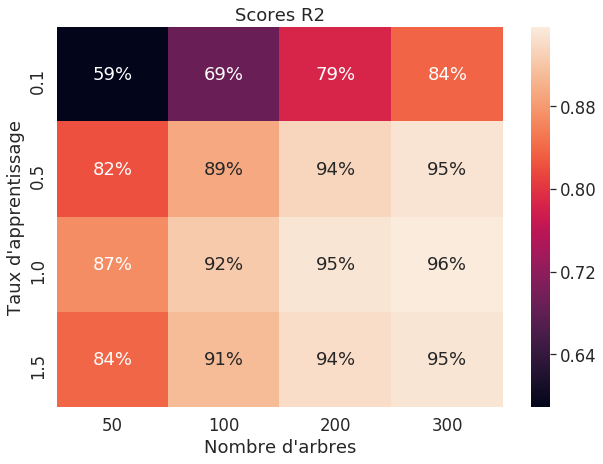

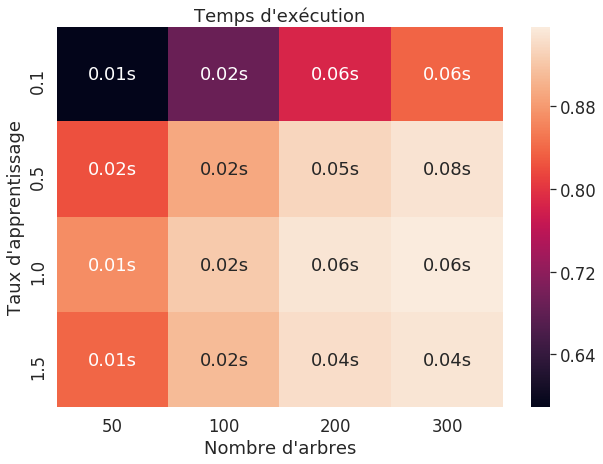

In [53]:
plot_grid_results(cv_grid)

### Recherche aléatoire d'hyper-paramètres

In [54]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform, randint

In [55]:
grid_params = { 'learning_rate': uniform(scale=2.0), 'n_estimators': randint(low=100, high=501) }

cv_random = RandomizedSearchCV(xgb.XGBRegressor(), grid_params, n_jobs=5, scoring='r2',
                   verbose=3, refit=True, return_train_score=True)

cv_random.fit(X_train, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    8.3s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=5,
          param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f059dc0c748>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f059dc0cb70>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='r2', verbose=3)

In [56]:
cv_random.best_params_

{'learning_rate': 0.9104261185903701, 'n_estimators': 466}

In [57]:
regressor = xgb.XGBRegressor(learning_rate=1.28, n_estimators=343)
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1.28, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=343,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## Stabilité et intervalles de confiance



In [58]:
from sklearn.model_selection import KFold

In [90]:
kfold = KFold(n_splits=50, shuffle=True)

outputs = []
for train_I, test_I in kfold.split(X_test):
    fold_x = X_test.iloc[train_I, :]
    fold_y = Y_test.values[train_I]
    fold_predict = regressor.predict(fold_x)
    outputs.append(r2_score(fold_y, fold_predict))

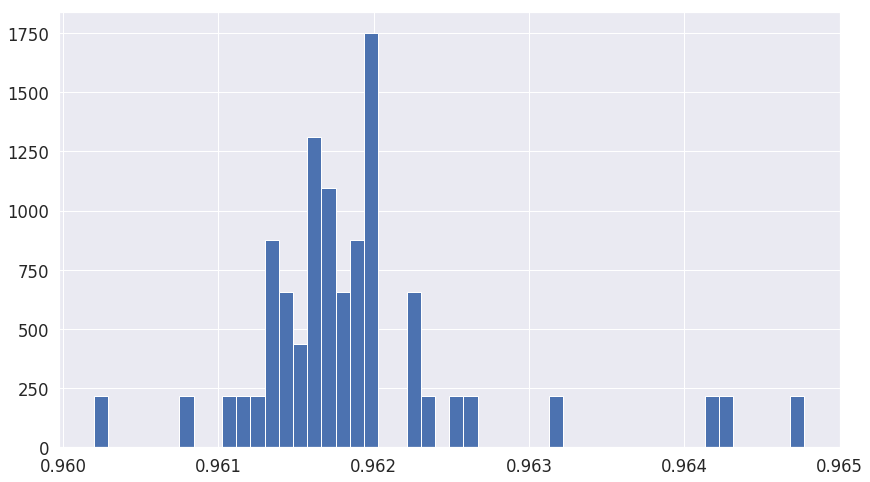

In [98]:
plt.figure(figsize=(14, 8))
plt.hist(outputs, bins=50, density=True)
plt.show()

Il nous reste à déterminer l'intervalle de confiance associé au score $R^2$. Ici, il suffit donc de fournir la moyenne des échantillons du Bootstrap associé à un intervalle de confiance. Dans l'idée, en supposant que l'on dispose de beaucoup d'observations, on pourrait approximer la distribution par une loi normale d'après le théorème central limite. Dans une partie des cas d'applications, on ne peut effectuer cette approximation du fait du manque d'individus dans l'ensemble de test.

Pour palier à ce défaut, il est possible de construire un intervalle de confiance non asymptotique à partir des quantiles empiriques observés. Si l'on souhaite fournir un intervalle de confiance non asymptotique de niveau $\alpha$, alors l'intervalle de confiance est tel que :

$$\mathbb{P}(R^2 \in I) \geq 1 - \alpha$$ 

Notons $\hat{q}$ la fonction quantile empirique de la distribution. Une méthode rapide pour déterminer un intervalle de confiance est d'utiliser la formule suivant :

$$\left[ \hat{R}^2 - \hat{q}\left( 1 - \frac{\alpha}{2} \right) \frac{\hat{\sigma}}{\sqrt{n}}, \hat{R}^2 + \hat{q}\left( 1 - \frac{\alpha}{2} \right) \frac{\hat{\sigma}}{\sqrt{n}} \right]$$

En utilisant des simplifications, par exemple en considérant que la distribution supposée est normale (valide dans le cas du TCL), pour un niveau de confiance de $95 \%$, l'intervalle se simplifie par :

$$\left[ \hat{R}^2 - 1.96 \frac{\hat{\sigma}}{\sqrt{n}}, \hat{R}^2 + 1.96 \frac{\hat{\sigma}}{\sqrt{n}} \right]$$


In [92]:
distrib = np.asarray(outputs)
mean = distrib.mean()
std = distrib.std()
expansion = 1.96 * std / np.sqrt(distrib.shape[0])
print("Intervalle de confiance de niveau 95% : {:2.1f}% ± {:2.3f}%".format(mean * 100, expansion * 100))

Intervalle de confiance de niveau 95% : 96.2% ± 0.022%
